# HW1 - Classifiers

## 1. Digit Recognizer

In [2]:
# import libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

#### (a)

In [3]:
# read training and testing data
training_data=pd.read_csv("Digit_Recognition_Data/train.csv")
testing_data=pd.read_csv("Digit_Recognition_Data/test.csv")

In [4]:
# function to display the MNIST digit indicated by the label parameter
def findDigit(label, data):
    digitIndex = list(labels).index(label)
    return data[digitIndex,:,:], digitIndex

In [5]:
labels=training_data['label'].values #extract data labels
data = training_data.drop(['label'],axis=1).values # extract data values
data_shaped = data.reshape(-1,28,28) # shape data for display

#### (b)

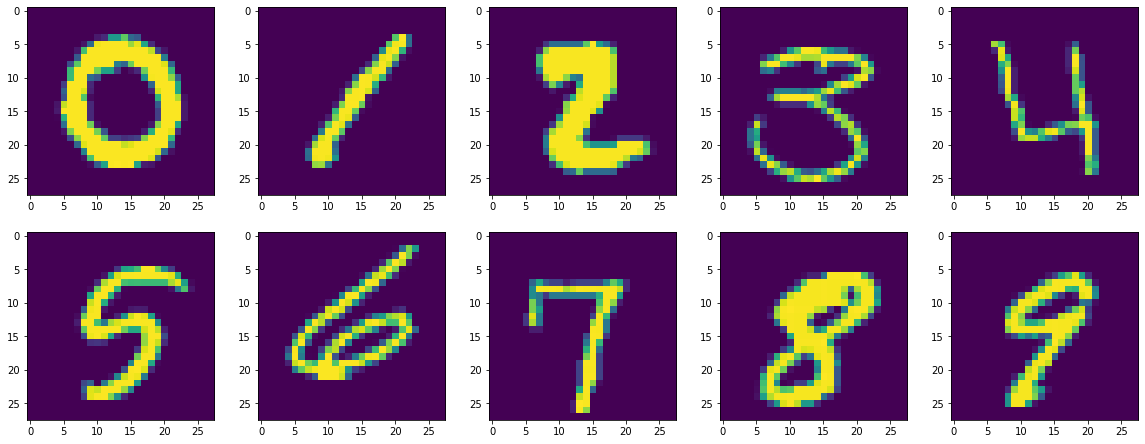

In [6]:
# plot one of each digit
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(5,5,i+1)
    digit, indx = findDigit(i, data_shaped)
    imshow(digit)

#### (c)

In [7]:
# function to calculate the prior probability of the class indicated by the label parameter
def calculatePrior(label):
    return np.count_nonzero(labels == label)/(42000)

Prior probability for  0 :  0.09838095238095237
Prior probability for  1 :  0.11152380952380953
Prior probability for  2 :  0.09945238095238096
Prior probability for  3 :  0.1035952380952381
Prior probability for  4 :  0.09695238095238096
Prior probability for  5 :  0.09035714285714286
Prior probability for  6 :  0.0985
Prior probability for  7 :  0.10478571428571429
Prior probability for  8 :  0.09673809523809523


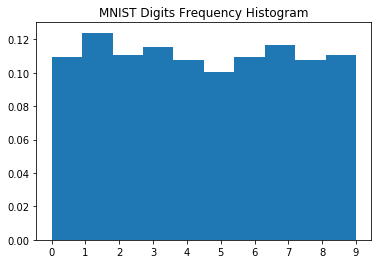

In [8]:
for i in range(0, 9):
    print ("Prior probability for ", i, ": ", calculatePrior(i))

# plots a histogram of the labels, density = True is for normalization
plt.hist(labels, bins = 10, density = True)
plt.xticks(np.arange(10), ['0','1','2', '3', '4', '5', '6', '7', '8', '9'])
plt.title('MNIST Digits Frequency Histogram')
plt.show()

# changed this because I think they wanted a normalized historgram, not just a plot of counts
#plt.bar(x, height= [counts(0), counts(1), counts(2), counts(3), counts(4), counts(5), counts(6), counts(7), counts(8), counts(9)]) 

#### (d)

In [9]:
def euclideanDist(img1, img2):
    return np.sqrt(np.sum((img2-img1)**2))

In [10]:
# find one of each digit
listofDigits = [findDigit(i, data_shaped) for i in range(10)]

# separate list of digits and their indices
digits = []
dig_indxs = []
for digitTuple in listofDigits:
    digits.append(digitTuple[0])
    dig_indxs.append(digitTuple[1])

In [11]:
# find nearest neighbor to each digit
# create a list of nearest neighbors to each example digit (example digits are the same ones printed before)

nearest_neighbors = []

for i, digit in enumerate(digits):
    indx = dig_indxs[i]
    
    #distances = np.linalg.norm(data - digit)
    for j, img in enumerate(data_shaped):
        # skip the image that we are finding the nearest neighbor for
        if j == indx:
            continue
        # calculate distance
        dist = euclideanDist(np.array(digit), np.array(img))
        # update best distance
        if j == 0:
            best_dist = dist
            nearest_n = img
            best_indx = j
        else:
            if dist < best_dist:
                best_dist = dist
                nearest_n = img
                best_indx = j
    nearest_neighbors.append((nearest_n, best_indx))

The nearest neighbor for the image selected for 0 is at index 12950
The nearest neighbor for the image selected for 1 is at index 29704
The nearest neighbor for the image selected for 2 is at index 9536
* The nearest neighbor for the image selected for 3 is at index 8981
The nearest neighbor for the image selected for 4 is at index 14787
The nearest neighbor for the image selected for 5 is at index 30073
The nearest neighbor for the image selected for 6 is at index 16240
The nearest neighbor for the image selected for 7 is at index 15275
The nearest neighbor for the image selected for 8 is at index 32586
The nearest neighbor for the image selected for 9 is at index 35742


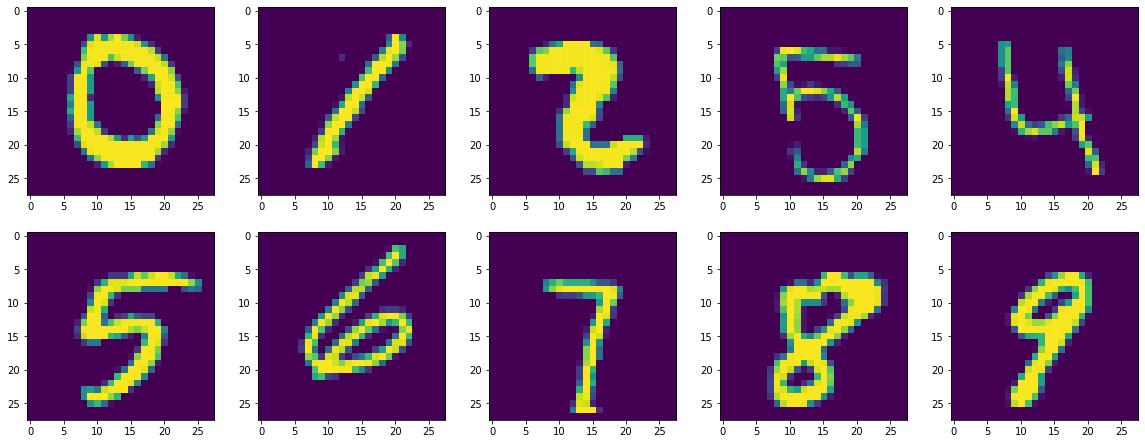

In [12]:
plt.figure(figsize=(20,20))
for i, neighbor in enumerate(nearest_neighbors):
    neighbor, indx = neighbor
    if i != labels[indx]:
        print('*', end = ' ')
    print('The nearest neighbor for the image selected for', i, 'is at index', indx)
    plt.subplot(5,5,i+1)
    imshow(neighbor)

#### (e)

In [13]:
zerosIndexes = []
onesIndexes = []
for i, label in enumerate(labels):
    if label == 0:
        zerosIndexes.append(i)
    elif label == 1:
        onesIndexes.append(i)

In [14]:
distZeros = []
for indx, i in enumerate(zerosIndexes[::40]): # change this back to full array before submission
    for j in zerosIndexes[indx+1:]:
        if i == j:
            continue
        distZeros.append(euclideanDist(data[i], data[j]))

In [15]:
distOnes = []
for indx,i in enumerate(onesIndexes[::40]): # change this back to full array before submission
    for j in onesIndexes[indx+1:]:
        if i == j:
            continue
        distOnes.append(euclideanDist(data[i], data[j]))

In [16]:
distImposters = []
for indx,i in enumerate(zerosIndexes[::40]): # change this back to full array before submission
    for j in onesIndexes[indx+1:]:
        distImposters.append(euclideanDist(data[i], data[j]))

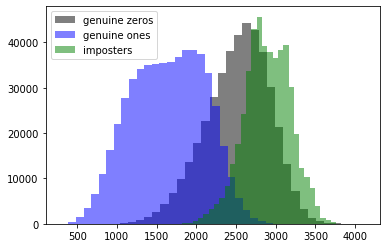

In [17]:
plt.hist(distZeros, color = 'k', label = 'genuine zeros', bins = 32, alpha = 0.5)
plt.hist(distOnes, color = 'b', label = 'genuine ones', bins = 32, alpha = 0.5)
plt.hist(distImposters, color = 'g', label = 'imposters', bins = 32, alpha = 0.5)
plt.legend()

#### (f)

In [18]:
zeroOneLabels = [0 for i in zerosIndexes]
for i in onesIndexes:
    zeroOneLabels.append(1)

#### (g)

In [23]:
def KNNclassify(mynum, nums, labels, k):
    '''This function goes through all of the MNIST digits (nums) and checks if it is a nearest 
    neighbor to "mynum" which is a test digit that we are trying to see if we can classify after
    spliting the training data set into a test set and train set. The nums are all of the MNIST
    numbers split into the training set, the labels are all of the labels corresponding to nums.
    Finally, k is the number of neighbors.'''
    
    # find nearest neighbors
    neighbors = []
    for i, num in enumerate(nums):
        # find distance of myitem to the item we are checking
        distance = euclideanDist(mynum, num)
        
        # start with the first k items in nums
        if len(neighbors) < k: 
            neighbors.append((distance, labels[i]))
            # sort in ascending order by distance
            neighbors = sorted(neighbors)
        
        # if the distance of this item is less than max distance replace max item with this one
        elif neighbors[len(neighbors)-1][0] > distance: 
            neighbors[len(neighbors)-1] = (distance, labels[i])
            # sort in ascending order by distance
            neighbors = sorted(neighbors)
    
    # need to determine where to classify based on the labels of the neighbors   
    # the classes are just 0-9, so we can represent in an array
    class_nums = np.zeros(10)
    for neighbor in neighbors:
        class_nums[neighbor[1]] += 1
    
    # determine the best classifications based on the dict created for the neighbors
    best_guess = np.argmax(class_nums)
                
    return best_guess

#### (h)

In [116]:
# not tested yet
X = data[:5000] # remove this indexing before submission
Y = labels[:5000] # remove this indexing before submission
cv = KFold(3)

# initialize arrays for analysis
accuracy = []
predictions = []
actuals = []

# crossvalidation
for train, test in cv.split(X, Y):
    total = len(X[test])
    correct = 0
    # test all values in test data
    for i, testnum in enumerate(X[test]):
        best_guess = KNNclassify(testnum, X[train], Y[train], k = 3)
        predictions.append(best_guess)
        if best_guess == Y[test][i]: # check if the best_guess is the same as the label
            correct += 1
    # find the accuracy for this iteration
    accuracy.append((correct/total)*100)
    actuals += list(Y[test])

print('The average accuracy of a 3NN classifier after K-fold crossvalidation is ', np.mean(accuracy))

The average accuracy of a 3NN classifier after K-fold crossvalidation is  92.0599553558676


#### (i)

[[484   0   0   0   0   0   8   1   1   0]
 [  0 552   1   1   0   0   1   1   1   1]
 [  7  22 487   4   2   0   1  13   5   4]
 [  3   4   8 448   0   9   2   1   2   3]
 [  0   7   0   0 429   0   3   1   0  37]
 [  4   4   3  14   2 430   5   1   2   4]
 [  5   1   0   0   2   3 505   0   0   0]
 [  0  16   2   2   6   1   1 465   0  13]
 [  7  15   7  25   3  17   2   4 386  11]
 [  7   5   2   3  22   4   0  18   0 417]]


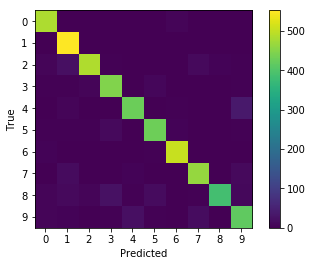

In [117]:
# need to use predictions and actuals to make a confusion matrix
confusion_m = confusion_matrix(actuals, predictions)
print(confusion_m)

# plot the confusion_matrix in a pretty way
fig, ax = plt.subplots()
imshow(confusion_m)
plt.colorbar()
classes = [0,1,2,3,4,5,6,7,8,9]
ax.set(xticks=classes,yticks=classes,xticklabels=classes,yticklabels=classes,ylabel='True',xlabel='Predicted');

#### (j)

In [118]:
# not run yet
all_predictions = []
for i, testnum in enumerate(testing_data.values):
    all_predictions.append(KNNclassify(testnum, data, labels, k = 3))

all_pred_df = pd.Dataframe(all_predictions)
all_pred_df.to_csv('MNIST_submission_Simi_Eva.csv')

KeyboardInterrupt: 

## 2. The Titanic Disaster

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [269]:
# read training and testing data
training_data_t=pd.read_csv("Titanic_Data/train_titanic.csv")
testing_data_t=pd.read_csv("Titanic_Data/test_titanic.csv")
labels_t=training_data_t['Survived'].values #extract data labels
data_t=training_data_t.drop(['Survived'],axis=1).values # extract data values

#lr = LogisticRegression()
#lr.fit(data_t, labels_t)